## Main figures for DG

We want to discuss the following simulations:
- High resolution
- 20 km no param
- 20 km ANN C = 0.5
- 20 km GM K = 200

The main thing we want to discuss are:
- Error in SSH
- Equlibrated KE and PE 
- APE reduction rates
- APE reduction cross-spectra

In [1]:
import xarray as xr
import xrft
import matplotlib.pyplot as plt
import numpy as np
from xgcm import Grid
from datatree import open_datatree, DataTree 

import sys
sys.path.append('../modules/')

%reload_ext autoreload
%autoreload 2

In [2]:
import DG_sim_analysis_modules as sam

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load HR model
dir_HR = '/scratch/db194/mom6/base_experiments_2025/DoubleGyre/double_gyre_HR/'

ds_HR = {}
oce_geom = xr.open_dataset(dir_HR + 'ocean_geometry.nc')
oce_geom =oce_geom.rename({'lonh':'xh', 'lath':'yh', 'lonq':'xq', 'latq':'yq'})
ver_coord = xr.open_dataset(dir_HR + 'Vertical_coordinate.nc')
ver_coord = ver_coord.rename({'Layer':'zl', 'Interface':'zi'})
ds_HR['prog'] = xr.open_mfdataset(dir_HR+'prog__*.nc', decode_times=False)
ds_HR['prog'] = xr.merge([ds_HR['prog'], oce_geom, ver_coord])
ds_HR['oce_stats'] = xr.open_dataset(dir_HR +'ocean.stats.nc', decode_times=False)

ERROR 1: PROJ: proj_create_from_database: Open of /ext3/miniforge/share/proj failed


In [68]:
not_before = False 
if not_before:
    ds_filt = sam.filter_dataset(ds_HR['prog'])
    ds_filt_coarse = sam.coarsen_dataset(ds_filt, 5)
    ds_filt['RV'] = ds_filt.dvdx - ds_filt.dudy
    ds_filt_coarse['RV'] = ds_filt_coarse.dvdx - ds_filt_coarse.dudy
    ds_filt_coarse['RV'].attrs = ds_HR['prog']['RV'].attrs
    ds_filt_coarse.to_netcdf('/scratch/db194/mom6/base_experiments_2025/DoubleGyre/double_gyre_HR/prog_filt_100km.nc')
else:
     ds_filt_coarse = xr.open_dataset('/scratch/db194/mom6/base_experiments_2025/DoubleGyre/double_gyre_HR/prog_filt_100km_coarse_4.nc')
     #ds_filt_coarse['Ah'] = oce_geom['Ah'].coarsen(xh=5, yh=5).sum()

In [6]:
ds_HR['prog'] = sam.add_energy_metrics(ds_HR['prog'])

In [69]:
ds_filt_coarse

<xarray.Dataset>
Dimensions:    (Time: 720, zl: 2, yh: 100, xh: 110, zi: 3)
Coordinates:
  * yh         (yh) float64 30.1 30.3 30.5 30.7 30.9 ... 49.3 49.5 49.7 49.9
  * zl         (zl) float64 1.035e+03 1.036e+03
  * Time       (Time) float64 5.0 10.0 15.0 20.0 ... 3.59e+03 3.595e+03 3.6e+03
  * xh         (xh) float64 0.1 0.3 0.5 0.7 0.9 1.1 ... 21.1 21.3 21.5 21.7 21.9
  * zi         (zi) float64 1.034e+03 1.036e+03 1.037e+03
Data variables: (12/18)
    ubar       (Time, zl, yh, xh) float32 ...
    vbar       (Time, zl, yh, xh) float32 ...
    hbar       (Time, zl, yh, xh) float32 ...
    ebar       (Time, zi, yh, xh) float32 ...
    uphp       (Time, zl, yh, xh) float32 ...
    vphp       (Time, zl, yh, xh) float32 ...
    ...         ...
    dedx       (Time, zi, yh, xh) float64 ...
    dedy       (Time, zi, yh, xh) float64 ...
    dhdx       (Time, zl, yh, xh) float64 ...
    dhdy       (Time, zl, yh, xh) float64 ...
    RV         (Time, zl, yh, xh) float64 ...
    Ah         (yh, xh) float64 ...

In [7]:
res = [20]
C_ANN = np.array([0.0, 0.5])
C_GM = np.array([200])/1000
model_types = ['ANN','GM1000']
exp_dir = '/scratch/db194/mom6/base_experiments_2025/DoubleGyre/31Mar/'

In [8]:
%%time
exp_tree = sam.load_sims(exp_dir, model_types, res, C_ANN, C_GM)

Reading :res_20km_ANN_0.0
Reading :res_20km_ANN_0.5
Reading :res_20km_GM1000_0.2
CPU times: user 9.34 s, sys: 2.43 s, total: 11.8 s
Wall time: 2min 31s


In [9]:
Tsel = slice(360*3, 360*13)

## Plots - mean SSH

In [70]:
e_mean_HR = ds_HR['prog'].e.sel(Time=Tsel).mean('Time')

ds = exp_tree['ANN']['20']['0.0']['prog']
coarsen_points = int(len(e_mean_HR.xh)/len(ds.xh)) 

xh_LR = ds.xh
yh_LR = ds.yh

e_mean_HR_coarse2 = e_mean_HR.coarsen(xh=coarsen_points, yh=coarsen_points, boundary='trim').mean().interp(xh=xh_LR, yh=yh_LR)

In [71]:
e_mean_HR_coarse = ds_filt_coarse.ebar.sel(Time=Tsel).mean('Time').interp(xh=xh_LR, yh=yh_LR)

In [72]:
exp_tree = exp_tree.map_over_subtree(sam.ave_e)

In [73]:
err_LR = ((e_mean_HR_coarse - exp_tree['ANN']['20']['0.0']['ave_prog'].ave_e)**2).mean(['xh','yh'])**0.5
err_LR_ANN = ((e_mean_HR_coarse - exp_tree['ANN']['20']['0.5']['ave_prog'].ave_e)**2).mean(['xh','yh'])**0.5
err_LR_GM = ((e_mean_HR_coarse - exp_tree['GM1000']['20']['0.2']['ave_prog'].ave_e)**2).mean(['xh','yh'])**0.5

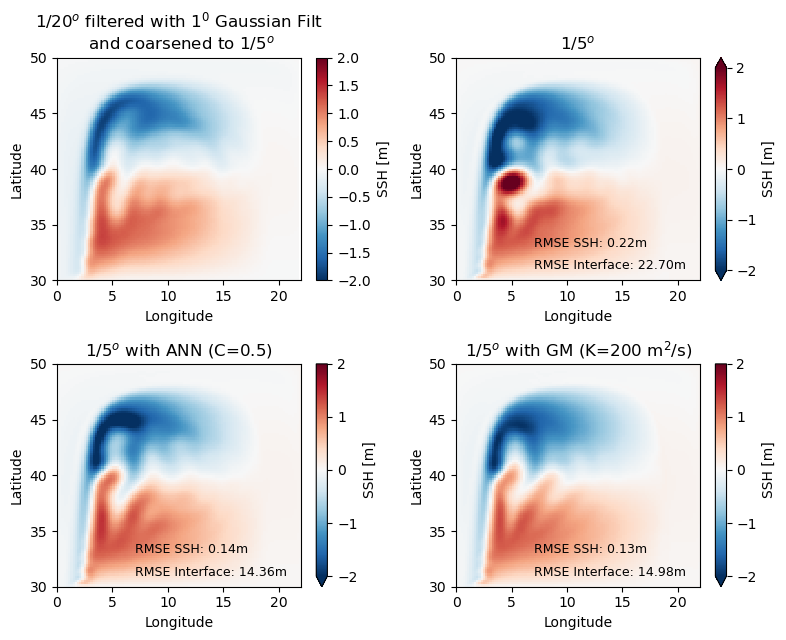

In [80]:
fig = plt.figure(figsize=(8, 6.5))

vmin = -2
zi = 0

# Panel 1
ax1 = plt.subplot(221)
e_mean_HR_coarse.isel(zi=zi).plot(ax=ax1, vmin=vmin,cbar_kwargs={'label': 'SSH [m]'})
ax1.set_title('1/20$^o$ filtered with 1$^0$ Gaussian Filt \n and coarsened to 1/5$^o$')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Panel 2
ax2 = plt.subplot(222)
exp_tree['ANN']['20']['0.0']['ave_prog'].ave_e.isel(zi=zi).plot(ax=ax2, vmin=vmin,cbar_kwargs={'label': 'SSH [m]'})
ax2.set_title('1/5$^o$')
ax2.text(7, 33, 'RMSE SSH: '+f"{err_LR.values[0]:.2f}" + 'm',  fontsize=9)
ax2.text(7, 31, 'RMSE Interface: '+f"{err_LR.values[1]:.2f}" + 'm',  fontsize=9)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Panel 3
ax3 = plt.subplot(223)
exp_tree['ANN']['20']['0.5']['ave_prog'].ave_e.isel(zi=zi).plot(ax=ax3, vmin=vmin,cbar_kwargs={'label': 'SSH [m]'})
ax3.set_title('LR ANN C=0.5')
ax3.text(7, 33, 'RMSE SSH: '+f"{err_LR_ANN.values[0]:.2f}" + 'm',  fontsize=9)
ax3.text(7, 31, 'RMSE Interface: '+f"{err_LR_ANN.values[1]:.2f}" + 'm',  fontsize=9)
ax3.set_title('1/5$^o$ with ANN (C=0.5)')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

# Panel 4
ax4 = plt.subplot(224)
exp_tree['GM1000']['20']['0.2']['ave_prog'].ave_e.isel(zi=zi).plot(ax=ax4, vmin=vmin,cbar_kwargs={'label': 'SSH [m]'})
ax4.set_title('LR GM K=200')
ax4.text(7, 33, 'RMSE SSH: '+f"{err_LR_GM.values[0]:.2f}" + 'm',  fontsize=9)
ax4.text(7, 31, 'RMSE Interface: '+f"{err_LR_GM.values[1]:.2f}" + 'm',  fontsize=9)
ax4.set_title('1/5$^o$ with GM (K=200 m$^2$/s)')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')

plt.tight_layout()

plt.savefig('mean_SSH_DG.png')

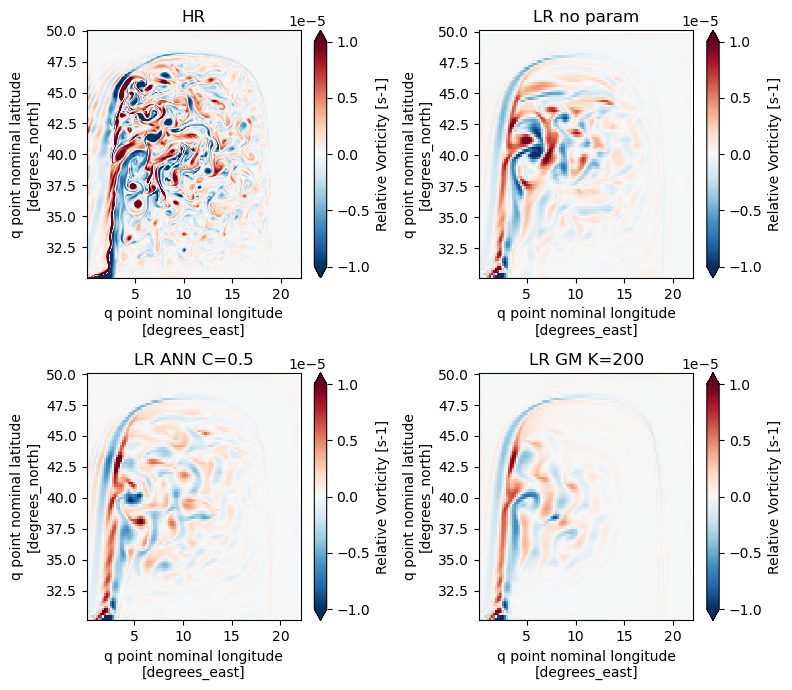

In [38]:
plt.figure(figsize=(8, 7))

vmin=-1e-5
zl = 0

plt.subplot(221)
ds_HR['prog'].RV.isel(Time=-1, zl=zl).plot(vmin = vmin)
plt.title('HR')

plt.subplot(222)
exp_tree['ANN']['20']['0.0']['prog'].RV.isel(Time=-1, zl=zl).plot(vmin=vmin)
plt.title('LR no param')

plt.subplot(223)
exp_tree['ANN']['20']['0.5']['prog'].RV.isel(Time=-1, zl=zl).plot(vmin=vmin)
plt.title('LR ANN C=0.5')

plt.subplot(224)
exp_tree['GM1000']['20']['0.2']['prog'].RV.isel(Time=-1, zl=zl).plot(vmin=vmin)
plt.title('LR GM K=200')

plt.tight_layout()

## KE and APE

In [75]:
exp_tree = exp_tree.map_over_subtree(sam.add_energy_metrics)

In [81]:
ds_filt_coarse = sam.add_energy_metrics_filt_coarse(ds_filt_coarse)

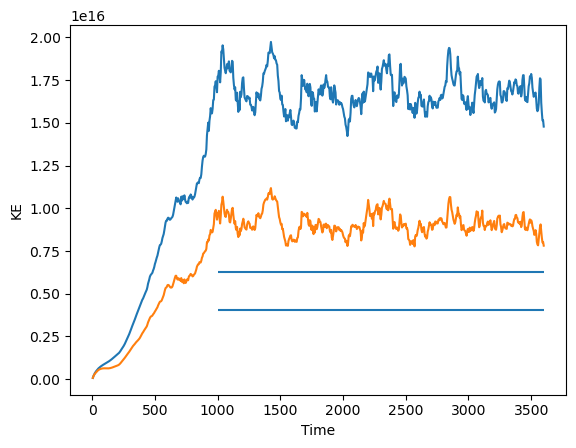

In [82]:
ds_HR['prog'].KE.plot()
ds_filt_coarse.KE.plot()
plt.hlines(ds_HR['prog'].MKE.values, 1000, 3600)
plt.hlines(ds_filt_coarse.MKE.values, 1000, 3600)

In [88]:
exp_names = ['4 km',  '4 km, filt', '20km', '20 km, ANN=0.5', '20km, GM=200']

In [93]:
exp_ds = [ds_HR['prog'], 
          ds_filt_coarse, 
          exp_tree['ANN']['20']['0.0']['prog'],
          exp_tree['ANN']['20']['0.5']['prog'],
          exp_tree['GM1000']['20']['0.2']['prog']]


MKE = np.zeros(len(exp_ds))
EKE = np.zeros(len(exp_ds))
MKE_SubFilter = np.zeros(len(exp_ds))
EKE_SubFilter = np.zeros(len(exp_ds))

MAPE = np.zeros(len(exp_ds))
EAPE = np.zeros(len(exp_ds))
MAPE_SubFilter = np.zeros(len(exp_ds))
EAPE_SubFilter = np.zeros(len(exp_ds))

for i, ds in enumerate(exp_ds):
    print(i)
    MKE[i] = ds['MKE'].values
    EKE[i] = ds['EKE'].sel(Time=Tsel).mean('Time').values

    
    MAPE[i] = ds['MAPE'].values
    EAPE[i] = ds['EAPE'].sel(Time=Tsel).mean('Time').values
    

EKE_SubFilter[1] = (EKE[0] - EKE[1])  
MKE_SubFilter[1] = (MKE[0] - MKE[1]) 
EAPE_SubFilter[1] = (EAPE[0] - EAPE[1])  
MAPE_SubFilter[1] = (MAPE[0] - MAPE[1])

0
1
2
3
4


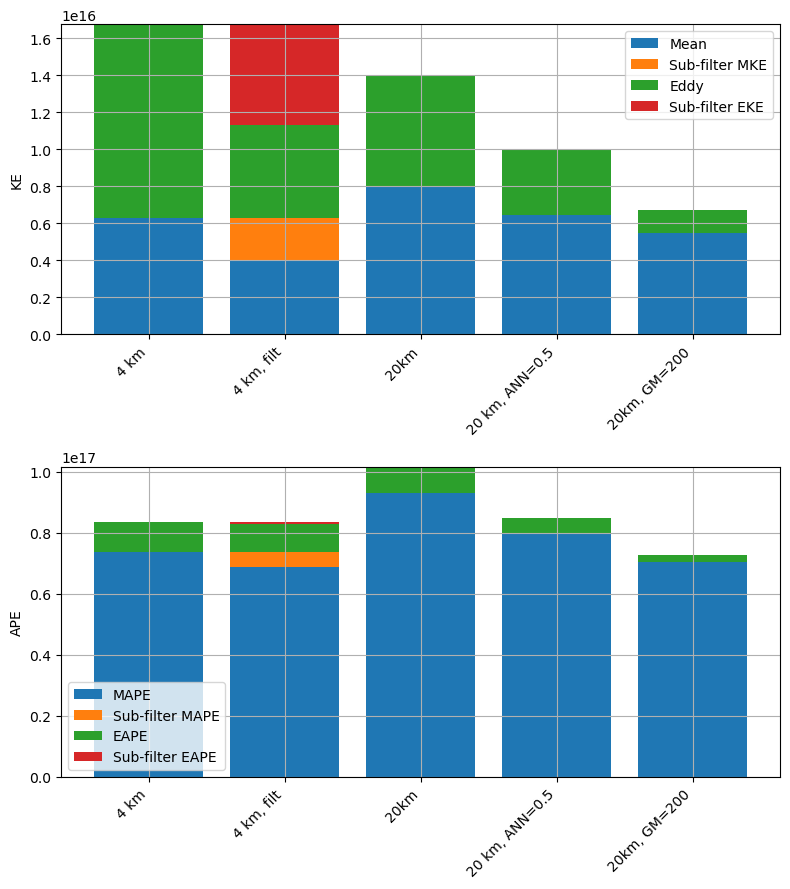

In [94]:
# Create the stacked bar plot
fig, ax = plt.subplots(2,1, figsize=(8, 9))

x = np.arange(len(exp_names))

# Plot the resolved part (bottom)
ax[0].bar(x, MKE, label='Mean')

# Plot the param part (stacked on top)
ax[0].bar(x, MKE_SubFilter, bottom=MKE, label='Sub-filter MKE')

# Plot the param part (stacked on top)
ax[0].bar(x, EKE, bottom=MKE+MKE_SubFilter, label='Eddy')


ax[0].bar(x, EKE_SubFilter, bottom=MKE+EKE+MKE_SubFilter, label='Sub-filter EKE')


# Labeling
ax[0].set_xticks(x)
ax[0].set_xticklabels(exp_names, rotation=45, ha='right')
ax[0].set_ylabel('KE')
#ax.set_title('Stacked Vbar (Resolved + Param)')
ax[0].legend()

#ax[0].set_ylim(0, 1.3e17)
ax[0].grid()


# Plot the resolved part (bottom)
ax[1].bar(x, MAPE, label='MAPE')

# Plot the param part (stacked on top)
ax[1].bar(x, MAPE_SubFilter, bottom=MAPE, label='Sub-filter MAPE')


# Plot the param part (stacked on top)
ax[1].bar(x, EAPE, bottom=MAPE+MAPE_SubFilter, label='EAPE')

# Plot the param part (stacked on top)
ax[1].bar(x, EAPE_SubFilter, bottom=MAPE+MAPE_SubFilter+EAPE, label='Sub-filter EAPE')


# Labeling
ax[1].set_xticks(x)
ax[1].set_xticklabels(exp_names, rotation=45, ha='right')
ax[1].set_ylabel('APE')
#ax.set_title('Stacked Vbar (Resolved + Param)')
ax[1].legend()

#ax[1].set_ylim(1.1e18, 1.4e18)
ax[1].grid()

plt.tight_layout()

#plt.savefig('energy_levels_DG.png')

### APE reduction rates 

In [73]:
exp_tree = exp_tree.map_over_subtree(sam.add_PE_reduction_rate)

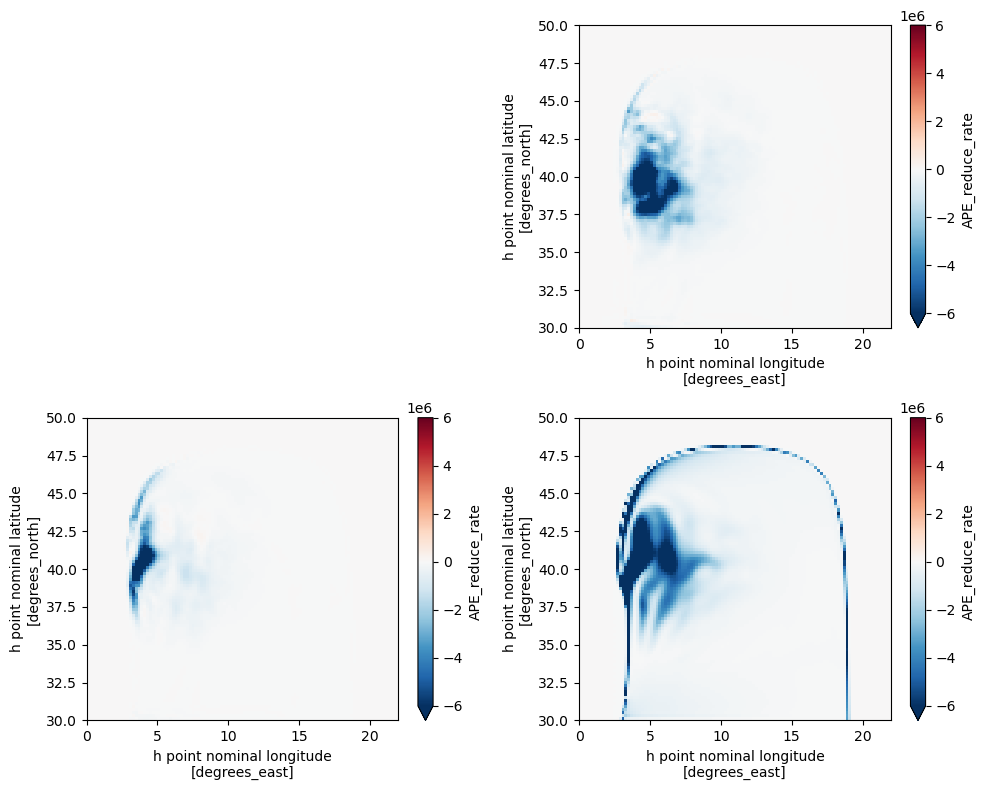

In [80]:
plt.figure(figsize=(10, 8 ))

vmin = -6e6

plt.subplot(222)
exp_tree['ANN']['20']['0.0']['prog']['APE_reduce_rate'].plot(vmin=vmin)

plt.subplot(223)
exp_tree['ANN']['20']['0.5']['prog']['APE_reduce_rate'].plot(vmin=vmin)

plt.subplot(224)
exp_tree['GM1000']['20']['0.2']['prog']['APE_reduce_rate'].plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')

plt.tight_layout()

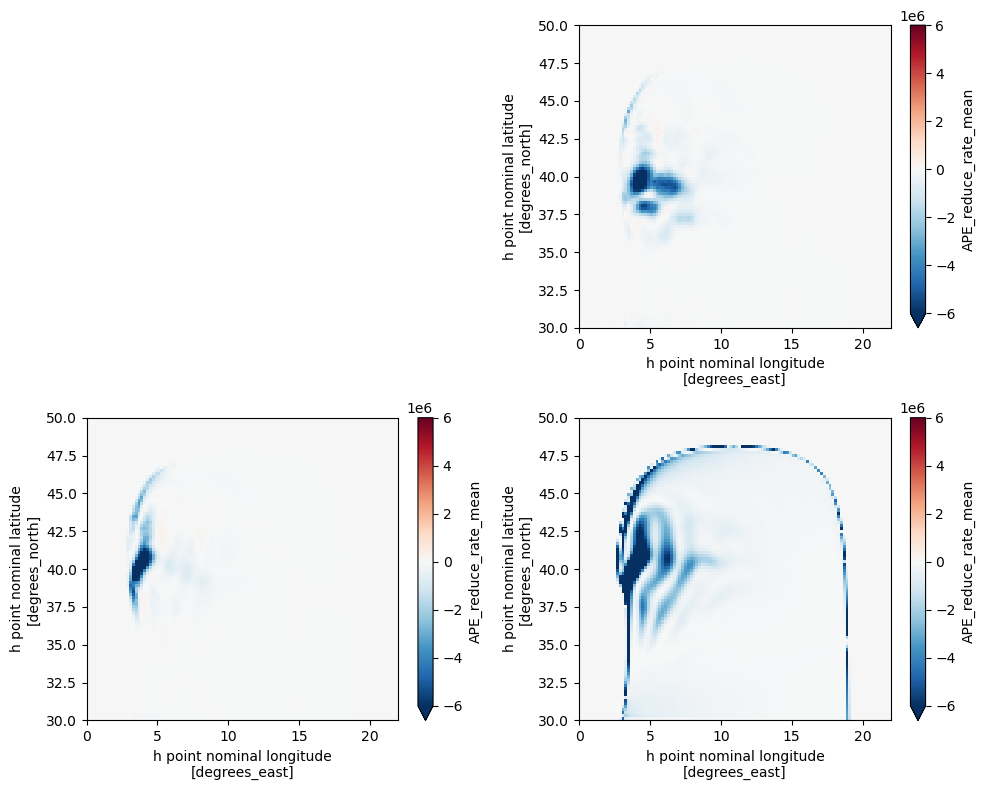

In [81]:
plt.figure(figsize=(10, 8 ))

vmin = -6e6

plt.subplot(222)
exp_tree['ANN']['20']['0.0']['prog']['APE_reduce_rate_mean'].plot(vmin=vmin)

plt.subplot(223)
exp_tree['ANN']['20']['0.5']['prog']['APE_reduce_rate_mean'].plot(vmin=vmin)

plt.subplot(224)
exp_tree['GM1000']['20']['0.2']['prog']['APE_reduce_rate_mean'].plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')

plt.tight_layout()

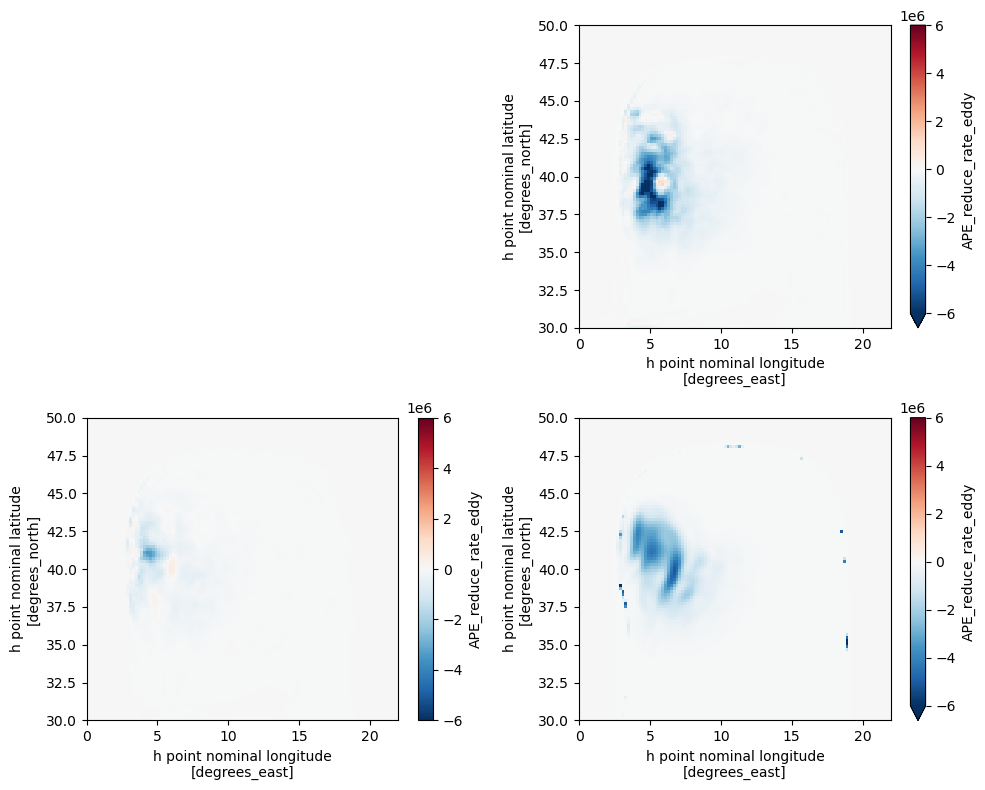

In [82]:
plt.figure(figsize=(10, 8 ))

vmin = -6e6

plt.subplot(222)
exp_tree['ANN']['20']['0.0']['prog']['APE_reduce_rate_eddy'].plot(vmin=vmin)

plt.subplot(223)
exp_tree['ANN']['20']['0.5']['prog']['APE_reduce_rate_eddy'].plot(vmin=vmin)

plt.subplot(224)
exp_tree['GM1000']['20']['0.2']['prog']['APE_reduce_rate_eddy'].plot(vmin=vmin, vmax=-vmin, cmap='RdBu_r')

plt.tight_layout()